## Import Libraries

In [1]:
import pandas as pd
import pandas_profiling as pdpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow
print(tensorflow.__version__)
# from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import tensorflow.keras.backend as K
from RegscorePy import *
print("GPU Available: ", tensorflow.test.is_gpu_available())



2.1.0


Using TensorFlow backend.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


## Helper Methods

In [2]:
def write_dict_to_json(path, content):
    with open(path + '.json', 'w') as file:
        file.write(json.dumps(content, ensure_ascii=False))
    
def write_str_to_txt(path, content):
    text_file = open(path + ".txt", "w")
    text_file.write(content) 
    text_file.close()

def plot_actual_vs_predicted(actual_column, predicted_column):
    plt.plot(list(range(1, len(actual_column) + 1)), actual_column, color='b', label='actual')
    plt.plot(list(range(1, len(actual_column) + 1)), predicted_column, color='r', label='predicted')
    plt.legend(loc='best')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted')
    plt.close()
    
def plot_actual_vs_predicted_scatter_bisector(actual_column, predicted_column):
    fig, ax = plt.subplots()
    ax.scatter(actual_column, predicted_column)
    ax.plot([actual_column.min(), actual_column.max()], [predicted_column.min(), predicted_column.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted_scatter_plot')
    plt.close()
    
    
def generate_lags_for(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def error_metrics(y_test, y_pred, nb_columns, nb_param):
    n = len(y_test)
    #convert to float for it to work for AIC and BIC data should all be of the same format i.e float not mix of types
    y_test_f =  [float(item) for item in y_test.values]
    y_predict_f =  [float(item) for item in y_pred]
    test_scores = {}
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test_f, y_predict_f)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    accuracy = 100 - np.mean(mape_score)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    r2 = str(round(r2_Score, 2))
    adjusted_r2 = str(round(adjusted_r2, 2))
    mae = str(round(mae_score, 2))
    mse = str(round(mse_score, 2))
    rmse = str(round(rmse_score, 2))
    re = str(round(re, 2))
    spearman = str(round(spearman_corr, 2))
    mape = str(round(mape_score, 2)) + "%"
    accuracy = str(round(accuracy, 2)) + "%"
    
    nmi = 1
#     normalized_mutual_info_score(y_test_n, y_pred)
    
#     nmi = 0
#     inm = drv.information_mutual_normalised(y_test, y_pred)
#     array_sum = np.sum(inm)
#     inm_has_nan = np.isnan(array_sum)
#     if inm_has_nan:
#         nmi = "NaN"
#     else:
#         nmi = str(inm)


    def calculate_aic(n, mse, num_params):
        aic = n * log(mse) + 2 * num_params
        return aic

    def calculate_bic(n, mse, num_params):
        bic = n * log(mse) + num_params * log(n)
        return bic

    aic = str(round(calculate_aic(len(y_test), mse_score, nb_param), 2))
    bic = str(round(calculate_bic(len(y_test), mse_score, nb_param), 2))

    test_scores["average output"] =  str(y_test.mean())
    test_scores["R2"] = r2
    test_scores["Adjusted R2"] = adjusted_r2
    test_scores["MAE"] = mae
    test_scores["MSE"] = mse
    test_scores["RMSE"] = rmse
    test_scores["Relative Error"] = re
    test_scores["Spearman"] = spearman
    test_scores["MAPE"] = mape
    test_scores["Accuracy"] = accuracy
    test_scores["Information Mutal Normalised"] = nmi
    test_scores["AIC"] = aic
    test_scores["BIC"] = bic
    return test_scores

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

## Get the data

In [3]:
input_path = "gs://agriculture-sara/Data sets/Experiments/Experiment Details.xlsx"
output_path = "Daily Experiments/Base/Manual All/"
df_experiment = pd.read_excel(input_path, "Daily")
df_experiment

Name       Category Sub Category  \
0                  All Sites   Manual Bowen      Cleaned   
1            Ameriflux Sites   Manual Bowen      Cleaned   
2             Euroflux Sites   Manual Bowen      Cleaned   
3   Ameriflux Euroflux Sites   Manual Bowen      Cleaned   
4                  All Sites   Manual Bowen      Imputed   
5            Ameriflux Sites   Manual Bowen      Imputed   
6             Euroflux Sites   Manual Bowen      Imputed   
7   Ameriflux Euroflux Sites   Manual Bowen      Imputed   
8                  All Sites  Library Bowen      Cleaned   
9            Ameriflux Sites  Library Bowen      Cleaned   
10            Euroflux Sites  Library Bowen      Cleaned   
11                 All Sites    Library Ebr      Cleaned   
12           Ameriflux Sites    Library Ebr      Cleaned   
13            Euroflux Sites    Library Ebr      Cleaned   

                                          Description    Model name  
0   Trained and tested on all the sites with dropp...   All_M_Cl.h5  
1   Trained and tested on Ameriflux sites with dro...    Am_M_Cl.h5  
2   Trained and tested on Euroflux Sites with drop...    Ef_M_Cl.h5  
3   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Cl.h5  
4   Trained and tested on all the sites with imput...   All_M_Im.h5  
5   Trained and tested on Ameriflux sites with imp...    Am_M_Im.h5  
6   Trained and tested on Euroflux Sites with impu...    Ef_M_Im.h5  
7   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Im.h5  
8   Trained and tested on all the sites with dropp...  All_LB_Cl.h5  
9   Trained and tested on Ameriflux sites with dro...   Am_LB_Cl.h5  
10  Trained and tested on Euroflux Sites with drop...   Ef_LB_Cl.h5  
11  Trained and tested on all the sites with dropp...  All_LE_Cl.h5  
12  Trained and tested on Ameriflux sites with dro...   Am_LE_Cl.h5  
13  Trained and tested on Euroflux Sites with drop...   Ef_LE_Cl.h5

In [5]:
input_path = "gs://agriculture-sara/Data sets/Residual Analysis Datasets/Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Residual Analysis Datasets/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Clusters/Modeling/Kmeans/2/TA/kmeans_TA_Cluster_1.csv"
# input_path = "gs://agriculture-sara/Data sets/Clusters/Modeling/Kmeans/2/TA_RH/kmeans_TA_RH_Cluster_1.csv"

# input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 3/All_Manual_Imputed.csv"
df = pd.read_csv(input_path, delimiter=',')

# df = df[df["Site Id"].str.startswith('US-')]

columnsToDrop = ['Vegetation', 'Latitude', 'Longitude', 'Climate',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'Climate_1', 'Climate_2', 'Climate_3',
                 'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                 'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                 'Longitude_5', 'Longitude_6',
                 'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                 'H_bowen_corr-5', 'C_BOWENS',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_bowen_corr',
                 'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                 'Elevation(m)_5', 'Elevation(m)_6',
                 'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']


# columnsToDrop = ['Year','Month','Day', 'Latitude','Longitude',
#                  'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
#                  'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
#                  'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
#                  'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr','LE_ebr_corr(mm)',
#                  'ET_bowen','ET_bowen_corr','ET_bowen_corr_mm','ET_ebr','ET_ebr_corr',
#                  'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
#                  'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
#                  'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1', 'ETo',
#                  'Climate_2','Climate_3', 'Latitude_1',
#                  'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
#                  'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
#                  'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
#                  'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'SW_IN']


df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)


output_column = "LE_bowen_corr_mm"
df = df[df[output_column].between(1, 15)]

df.head()

Date Site Id  Year  Month  Day  Site_1  Site_2  Site_3  Site_4  Site_5  \
5  5/2/2000  FI-Jok  2000      5    2       1       0       1       0       1   
6  5/4/2000  FI-Jok  2000      5    4       1       0       1       0       1   
7  5/5/2000  FI-Jok  2000      5    5       1       0       1       0       1   
8  5/6/2000  FI-Jok  2000      5    6       1       0       1       0       1   
9  5/7/2000  FI-Jok  2000      5    7       1       0       1       0       1   

   ...  Eeflux_NDVI-2  Eeflux_NDVI-3  Eeflux_NDVI-4  Eeflux_NDVI-5  \
5  ...          0.402          0.413          0.316         -0.053   
6  ...          0.453          0.402          0.413          0.316   
7  ...          0.481          0.453          0.402          0.413   
8  ...          0.449          0.481          0.453          0.402   
9  ...          0.363          0.449          0.481          0.453   

   Eeflux_Albedo  Eeflux_Albedo_1  Eeflux_Albedo-2  Eeflux_Albedo-3  \
5          0.122            0.122            0.121            0.121   
6          0.122            0.122            0.122            0.121   
7          0.121            0.122            0.122            0.122   
8          0.121            0.121            0.122            0.122   
9          0.121            0.121            0.121            0.122   

   Eeflux_Albedo-4  Eeflux_Albedo-5  
5            0.110            0.507  
6            0.121            0.110  
7            0.121            0.121  
8            0.122            0.121  
9            0.122            0.122  

[5 rows x 55 columns]

In [6]:
df.shape

(10916, 55)

In [34]:
test_path = "gs://agriculture-sara/Data sets/Residual Analysis Datasets/manual_test_dataset.csv"
df_test = pd.read_csv(test_path, delimiter=',')
print(df_test.shape)

(2182, 51)


In [7]:
lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns)
print(df.columns)
print(df.shape)

num_features = df.shape[1]
print(num_features)

Index(['Date', 'Site Id', 'Year', 'Month', 'Day', 'Site_1', 'Site_2', 'Site_3',
       'Site_4', 'Site_5', 'Site_6', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1',
       'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4',
       'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5',
       'LE_bowen_corr_mm', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo_1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')
(10916, 55)
55


In [36]:
# unique_sites = df["Site Id"].unique()
# sum_dup = 0
# for i in range(len(unique_sites)):
#     site = unique_sites[i]
#     df_tmp = df[df["Site Id"] == site][["Site Id", "Date", output_column]]

#     duplicateDFRow = df_tmp[df_tmp.duplicated()]
#     print(len(duplicateDFRow), "for site", site)
#     sum_dup += len(duplicateDFRow)

# print(sum_dup)

In [28]:
# TRAIN_RATIO = 0.6
# TEST_RATIO = 0.2

# def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
#     X_train = pd.DataFrame()
#     X_test = pd.DataFrame()
#     Y_train = pd.DataFrame()
#     Y_test = pd.DataFrame()
#     unique_sites = df["Site Id"].unique()
#     print("Number of sites:", len(unique_sites))

#     for site in unique_sites:
#         df_site = df[df["Site Id"] == site]
#         X = df_site
#         train_index = int(X.shape[0] * TRAIN_RATIO)
#         test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

#         X_train = X_train.append(X[:train_index], ignore_index = True)
#         X_test = X_test.append(X[train_index:], ignore_index = True)
#         Y_train = Y_train.append(X[:train_index], ignore_index = True)
#         Y_test = Y_test.append(X[train_index:], ignore_index = True)

#     Y_train = Y_train[[output_column]]
#     Y_test = Y_test[[output_column]]
   
#     X_train = X_train.drop([output_column], axis = 1)
#     X_test = X_test.drop([output_column], axis = 1)
   
#     return X_train, Y_train, X_test, Y_test

# X_train, Y_train, X_test, Y_test = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
# print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
# print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape)

# columnToDrop = "Site Id"
# X_train.drop([columnToDrop], axis = 1, inplace=True)
# X_test.drop([columnToDrop], axis = 1, inplace=True)

In [37]:
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)

(10911, 55)


In [38]:
def split_train_test(df, TRAIN_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)

    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_train_test(df, 0.8)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape)

site_id = X_test["Site Id"]
dates = X_test["Date"]
# columnToDrop = ["Site Id", "Date"]
# X_train.drop(columnToDrop, axis = 1, inplace=True)
# X_test.drop(columnToDrop, axis = 1, inplace=True)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Number of sites: 26
X_train shape: (8718, 54) X_test shape: (2193, 54)
Y_train shape: (8718, 1) Y_test shape: (2193, 1)


In [28]:
X_test.columns

Index(['Year', 'Month', 'Day', 'Site_1', 'Site_2', 'Site_3', 'Site_4',
       'Site_5', 'Site_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'Eeflux_LST',
       'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3', 'Eeflux_LST-4',
       'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1', 'Eeflux_NDVI-2',
       'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5', 'Eeflux_Albedo',
       'Eeflux_Albedo_1', 'Eeflux_Albedo-2', 'Eeflux_Albedo-3',
       'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')

In [40]:
X_test["Site Id"] = site_id
X_test["Date"] = dates
X_test["LE_bowen_corr_mm"] = Y_test
X_test.to_csv('gs://agriculture-sara/Data sets/manual_test_all_dataset.csv')

In [30]:
df_test = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)
df_test["Site Id"] = site_id
df_test["Date"] = dates
df_test.to_csv('gs://agriculture-sara/Data sets/manual_test_scaled_dataset.csv')

## Split data into train, test, validation

In [16]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    X_valid = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    Y_valid = pd.DataFrame()
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))
    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
#         X = df_site.drop([output_column], axis = 1)
#         Y = df_site[output_column]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))
        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:test_index], ignore_index = True)
        X_valid = X_valid.append(X[test_index:], ignore_index = True)
        
        Y_train = Y_train.append(X[:train_index], ignore_index = False)
        Y_test = Y_test.append(X[train_index:test_index], ignore_index = False)
        Y_valid = Y_valid.append(X[test_index:], ignore_index = False)
    
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
    Y_valid = Y_valid[[output_column]]
    
    X_train = X_train.drop([output_column], axis = 1) 
    X_test = X_test.drop([output_column], axis = 1) 
    X_valid = X_valid.drop([output_column], axis = 1) 
    
    return (X_train, Y_train, X_test, Y_test, X_valid, Y_valid)
    
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape, "Y_valid shape:", Y_valid.shape)

# columnToDrop = "Site Id"
# X_train.drop([columnToDrop], axis = 1, inplace=True)
# X_test.drop([columnToDrop], axis = 1, inplace=True)
# X_valid.drop([columnToDrop], axis = 1, inplace=True)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_valid_scaled = scaler.transform(X_valid)

# n_input = X_train.shape[1]
# n_classes = 1
# print("num of input:", n_input, "num of classes:", n_classes)

# nb_columns = len(list(df.columns.values)) - 1

Number of sites: 26
X_train shape: (6536, 54) X_test shape: (2182, 54) X_valid shape: (2193, 54)
Y_train shape: (6536, 1) Y_test shape: (2182, 1) Y_valid shape: (2193, 1)


In [13]:
X_test.head()

Date Site Id  Year  Month  Day  Site_1  Site_2  Site_3  Site_4  \
0   9/5/2002  FI-Jok  2002      9    5       1       0       1       0   
1   9/6/2002  FI-Jok  2002      9    6       1       0       1       0   
2   9/7/2002  FI-Jok  2002      9    7       1       0       1       0   
3   9/9/2002  FI-Jok  2002      9    9       1       0       1       0   
4  9/10/2002  FI-Jok  2002      9   10       1       0       1       0   

   Site_5  ...  Eeflux_NDVI-2  Eeflux_NDVI-3  Eeflux_NDVI-4  Eeflux_NDVI-5  \
0       1  ...          0.641          0.714          0.396          0.525   
1       1  ...          0.664          0.641          0.714          0.396   
2       1  ...          0.625          0.664          0.641          0.714   
3       1  ...          0.639          0.625          0.664          0.641   
4       1  ...          0.029          0.639          0.625          0.664   

   Eeflux_Albedo  Eeflux_Albedo_1  Eeflux_Albedo-2  Eeflux_Albedo-3  \
0          0.152            0.155            0.156            0.152   
1          0.155            0.152            0.155            0.156   
2          0.162            0.155            0.152            0.155   
3          0.162            0.162            0.155            0.152   
4          0.161            0.162            0.162            0.155   

   Eeflux_Albedo-4  Eeflux_Albedo-5  
0            0.162            0.166  
1            0.152            0.162  
2            0.156            0.152  
3            0.155            0.156  
4            0.152            0.155  

[5 rows x 54 columns]

In [44]:
df_test["Site Id"] = X_test["Site"]
df_test["Date"] = X_test["Date"]
df_test.to_csv('gs://agriculture-sara/Data sets/Residual Analysis Datasets/manual_cleaned_test_dataset.csv')

## Prepare Json for Experiment Information

In [25]:
current_experiment = df_experiment.iloc[0, :]
experiment_info = current_experiment.to_dict()
experiment_info["Input Features"] = list(X_train.columns)
experiment_info["Output Feature"] = str(Y_train.columns[0])
experiment_info["Train Size"] = str(X_train.shape)
experiment_info["Validation Size"] = str(X_valid.shape)
experiment_info["Test Size"] = str(X_test.shape)


sorted_dict = OrderedDict(sorted(experiment_info.items(), key=lambda t: t[0]))
write_dict_to_json(output_path + "experiment_info", sorted_dict)

## Test Chapters

## Chapter 13: Penalize Large Weights with Weight Regularization

In [12]:
def fit_model(first_neuron=64,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.4,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    all_train, all_test = list(), list()
    for param in values:
        # Create model
        model = tensorflow.keras.Sequential()
        model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(param), activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'accuracy', 'mape'])
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        file_name = output_path + "_weight_test_" + str(param)
        mc = ModelCheckpoint(file_name, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
        history = model.fit(X_train_scaled,
                            Y_train,
                            validation_data=(X_valid_scaled, Y_valid),
                            epochs=300,
                           verbose=1,
                           callbacks=[mc, es])

        
        loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
        loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
        loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

        print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
        print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
        print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
        
        print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_mape, test_mape))
        all_train.append(train_mape)
        all_test.append(test_mape)
    
    plt.semilogx(values, all_train, label='train', marker='o')
    plt.semilogx(values, all_test, label='test', marker='o')
    plt.legend()
    plt.show()
    
fit_model()

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6272/6536 [===========================>..] - ETA: 0s - loss: 4.7660 - mse: 4.5196 - mae: 1.6226 - accuracy: 0.0000e+00 - mape: 53.2171
Epoch 00001: val_mape improved from inf to 54.09375, saving model to Daily Experiments/Base/Manual All/_weight_test_0.1


KeyboardInterrupt: 

## Chapter 14: Sparse Representations with Activity Regularization

In [12]:
def fit_model(first_neuron=64,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.4,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    values = [1e-1, 1e-2, 1e-3]
    all_train, all_test = list(), list()
    for param in values:
        # Create model
        model = tensorflow.keras.Sequential()
        model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(1e-4), activation=activation, activity_regularizer=l1(param)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'accuracy', 'mape'])
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        file_name = output_path + "_weight_test_" + str(param)
        mc = ModelCheckpoint(file_name, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
        history = model.fit(X_train_scaled,
                            Y_train,
                            validation_data=(X_valid_scaled, Y_valid),
                            epochs=300,
                           verbose=1,
                           callbacks=[mc, es])

        
        loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
        loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
        loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

        print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
        print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
        print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
        
        print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_mape, test_mape))
        all_train.append(train_mape)
        all_test.append(test_mape)
    
    plt.semilogx(values, all_train, label='train', marker='o')
    plt.semilogx(values, all_test, label='test', marker='o')
    plt.legend()
    plt.show()
    
fit_model()

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6208/6536 [===========================>..] - ETA: 0s - loss: 6.1864 - mse: 4.7828 - mae: 1.6606 - accuracy: 0.0000e+00 - mape: 52.2607
Epoch 00001: val_mape improved from inf to 47.05235, saving model to Daily Experiments/Base/Manual All/_weight_test_0.1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_0.1/assets
6536/6536 [==============================] - 3s 498us/sample - loss: 6.1303 - mse: 4.7365 - mae: 1.6507 - accuracy: 0.0000e+00 - mape: 51.9267 - val_loss: 3.8414 - val_mse: 2.6245 - val_mae: 1.2590 - val_accuracy: 0.0000e+00 - val_mape: 47.0523
Epoch 2/300
6400/6536 [============================>.] - ETA: 0s - loss: 4.3684 - mse: 3.2492 - mae: 1.3510 - accuracy: 0.0000e+00 - mape: 44.1595
Epoch 00002: val_mape improved from 47.05235 to 46.19893, saving model to Daily Experiments/Base/Manual All/_weight_tes

## Chapter 15: Force Small Weights with Weight Constraints

In [14]:
def fit_model(first_neuron=64,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.4,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(1e-4), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'accuracy', 'mape'])
        
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    file_name = output_path + "_weight_test_"
    mc = ModelCheckpoint(file_name, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled,
                            Y_train,
                            validation_data=(X_valid_scaled, Y_valid),
                            epochs=300,
                           verbose=1,
                           callbacks=[mc, es])

        
    loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
    loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
    loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

    print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
    print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
    print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
        
    plt.subplot(211)
    plt.title('MSE Loss', pad=-40)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    
    plt.subplot(212)
    plt.title('MAPE Loss', pad=-40)
    plt.plot(history.history['mape'], label='train')
    plt.plot(history.history['val_mape'], label='validation')
    plt.legend()
    
    plt.show()
    
fit_model()

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6336/6536 [============================>.] - ETA: 0s - loss: 4.8098 - mse: 4.8094 - mae: 1.6684 - accuracy: 0.0000e+00 - mape: 54.5834
Epoch 00001: val_mape improved from inf to 52.86905, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/assets
6536/6536 [==============================] - 2s 338us/sample - loss: 4.7549 - mse: 4.7545 - mae: 1.6618 - accuracy: 0.0000e+00 - mape: 54.6793 - val_loss: 2.7253 - val_mse: 2.7248 - val_mae: 1.3180 - val_accuracy: 0.0000e+00 - val_mape: 52.8690
Epoch 2/300
6272/6536 [===========================>..] - ETA: 0s - loss: 3.1543 - mse: 3.1537 - mae: 1.3631 - accuracy: 0.0000e+00 - mape: 47.4832
Epoch 00002: val_mape improved from 52.86905 to 47.94141, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/a

In [27]:
def fit_model(first_neuron=64,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.4,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(1e-4), activation=activation,  kernel_constraint=unit_norm()))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'accuracy', 'mape'])
        
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    file_name = output_path + "_weight_test_"
    mc = ModelCheckpoint(file_name, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train_scaled,
                            Y_train,
                            validation_data=(X_valid_scaled, Y_valid),
                            epochs=300,
                           verbose=1,
                           callbacks=[mc, es])

        
    loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
    loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
    loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

    print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
    print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
    print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
        
    plt.subplot(211)
    plt.title('MSE Loss', pad=-40)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    
    plt.subplot(212)
    plt.title('MAPE Loss', pad=-40)
    plt.plot(history.history['mape'], label='train')
    plt.plot(history.history['val_mape'], label='validation')
    plt.legend()
    
    plt.show()
    
fit_model()

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6368/6536 [============================>.] - ETA: 0s - loss: 4.6412 - mse: 4.6348 - mae: 1.6482 - accuracy: 0.0000e+00 - mape: 54.0933
Epoch 00001: val_mape improved from inf to 49.38205, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/assets
6536/6536 [==============================] - 3s 434us/sample - loss: 4.6313 - mse: 4.6250 - mae: 1.6437 - accuracy: 0.0000e+00 - mape: 53.9133 - val_loss: 2.4700 - val_mse: 2.4636 - val_mae: 1.2375 - val_accuracy: 0.0000e+00 - val_mape: 49.3820
Epoch 2/300
6272/6536 [===========================>..] - ETA: 0s - loss: 3.1664 - mse: 3.1600 - mae: 1.3510 - accuracy: 0.0000e+00 - mape: 45.9685
Epoch 00002: val_mape improved from 49.38205 to 48.82783, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/a

## Chapter 16: Decouple Layers with Dropout

Train on 6536 samples, validate on 2193 samples
Epoch 1/300
6304/6536 [===========================>..] - ETA: 0s - loss: 4.1291 - mse: 4.1287 - mae: 1.5572 - accuracy: 0.0000e+00 - mape: 53.9029
Epoch 00001: val_mape improved from inf to 49.76455, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/assets
6536/6536 [==============================] - 2s 310us/sample - loss: 4.0677 - mse: 4.0673 - mae: 1.5461 - accuracy: 0.0000e+00 - mape: 53.6148 - val_loss: 2.5466 - val_mse: 2.5462 - val_mae: 1.2580 - val_accuracy: 0.0000e+00 - val_mape: 49.7646
Epoch 2/300
6208/6536 [===========================>..] - ETA: 0s - loss: 2.6405 - mse: 2.6400 - mae: 1.2423 - accuracy: 0.0000e+00 - mape: 44.4867
Epoch 00002: val_mape improved from 49.76455 to 42.07379, saving model to Daily Experiments/Base/Manual All/_weight_test_
INFO:tensorflow:Assets written to: Daily Experiments/Base/Manual All/_weight_test_/a

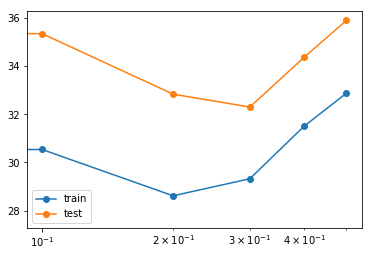

In [28]:
def fit_model(first_neuron=64,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.4,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    all_train, all_test = list(), list()
    for param in values:
        # Create model
        model = tensorflow.keras.Sequential()
        model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(1e-4), activation=activation))
        model.add(Dropout(param))
        model.add(Dense(1, activation="linear"))
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'accuracy', 'mape'])
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        file_name = output_path + "_weight_test_"
        mc = ModelCheckpoint(file_name, monitor='val_mape', mode='min', verbose=1, save_best_only=True)
        history = model.fit(X_train_scaled,
                            Y_train,
                            validation_data=(X_valid_scaled, Y_valid),
                            epochs=300,
                           verbose=1,
                           callbacks=[mc, es])

        
        loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
        loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
        loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

        print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
        print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
        print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)
        
        print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_mape, test_mape))
        all_train.append(train_mape)
        all_test.append(test_mape)
    
    plt.semilogx(values, all_train, label='train', marker='o')
    plt.semilogx(values, all_test, label='test', marker='o')
    plt.legend()
    plt.show()
    
fit_model()

## Create a keras wrapper model

In [ ]:
def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
#     model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae', 'accuracy', 'mape'])
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    return model

In [ ]:
create_model().summary

## Generate a keras Regression with a grid search with initial parameters

In [ ]:
model = KerasRegressor(build_fn=create_model)


# Prepare the Grid
param_grid = {
              'first_neuron':[64],
              'activation' : ['relu'],
              'init': ['uniform'],
              'dropout_rate' : [0.4],
              'dense_layer_sizes' : [1, 2, 3, 4],
              'optimizer' : ['Adam'],
              'loss': ['mean_squared_error'],
              'epochs':[200],
              'batch_size':[64]
             }

# param_grid = {
#               'first_neuron':[64, 48],
#               'activation' : ['softmax', 'tanh', 'relu'],
#               'init': ['he_uniform'],
#               'dropout_rate' : [0.4, 0.2],
#               'dense_layer_sizes' : [2],
#               'optimizer' : ['Adam'],
#               'loss': ['mean_absolute_percentage_error', 'mean_squared_logarithmic_error'],
#               'epochs':[400],
#               'batch_size':[64]
#              }


# param_grid = {
#               'first_neuron':[40],
#               'activation' : ['softmax', 'tanh', 'relu', 'linear'],
#               'init': ['he_uniform', 'normal'],
#               'dropout_rate' : [0.4, 0.3, 0.2],
#               'dense_layer_sizes' : [2, 5],
#               'optimizer' : ['Adam', 'RMSprop', 'Nadam', 'SGD'],
#               'epochs':[300],
#               'batch_size':[64]
#              }

# param_grid = {
#               'first_neuron':[64],
#               'activation' : ['relu'],
#               'init': ['he_uniform'],
#               'dropout_rate' : [0.4],
#               'dense_layer_sizes' : [2],
#               'optimizer' : ['Adam'],
#               'epochs':[300],
#               'batch_size':[64]
#              }

start_time = time.time()
print("start time:", start_time)
# GridSearch in action
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(output_path + current_experiment["Model name"], monitor='val_mape', mode='min', verbose=1, save_best_only=True)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs= 1, 
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose= 0)

grid_result = grid.fit(X_train_scaled,
                       Y_train, 
                       validation_data=(X_valid_scaled, Y_valid),
                       callbacks=[es, mc],
                       verbose=1)

## Summarize best hyper parameters results

In [118]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [22]:
import time
start_time = time.time()
print("start time:", start_time)

start time: 1593180027.0241084


In [26]:
print("%.5f seconds" % (time.time() - start_time))

22.83109 seconds


In [119]:
print("%s seconds" % (time.time() - start_time))

1.8633496761322021 seconds


## Re-run the data on the best hyper parameters

In [ ]:
# best_params = grid_result.best_params_
# model = create_model(best_params["first_neuron"],
#                     best_params["activation"],
#                     best_params["init"],
#                     best_params["dropout_rate"],
#                     best_params["dense_layer_sizes"],
#                     best_params["optimizer"])

best_params = param_grid
model = create_model(best_params["first_neuron"][0],
                    best_params["activation"][0],
                    best_params["init"][0],
                    best_params["dropout_rate"][0],
                    best_params["dense_layer_sizes"][0],
                    best_params["optimizer"][0],
                    best_params["loss"][0])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(output_path + current_experiment["Model name"], monitor='val_mape', mode='min', verbose=1, save_best_only=True)
history = model.fit(X_train_scaled,
                    Y_train,
                    validation_data=(X_valid_scaled, Y_valid),
                    epochs=best_params["epochs"][0],
                   verbose=1,
                   callbacks=[mc, es])

# model.save(output_path + current_experiment["Model name"])

Train on 2727 samples, validate on 918 samples
Epoch 1/500
2688/2727 [============================>.] - ETA: 0s - loss: 96.1750 - mse: 19.1004 - mae: 3.7658 - accuracy: 0.0000e+00 - mape: 96.1740
Epoch 00001: val_mape improved from inf to 91.80479, saving model to Daily Experiments/Base/Manual All/All_M_Cl.h5
2727/2727 [==============================] - 2s 719us/sample - loss: 96.1104 - mse: 19.0687 - mae: 3.7597 - accuracy: 0.0000e+00 - mape: 96.1095 - val_loss: 91.8058 - val_mse: 15.6395 - val_mae: 3.3367 - val_accuracy: 0.0000e+00 - val_mape: 91.8048
Epoch 2/500
2624/2727 [===========================>..] - ETA: 0s - loss: 89.0175 - mse: 17.6159 - mae: 3.5608 - accuracy: 0.0000e+00 - mape: 89.0158
Epoch 00002: val_mape improved from 91.80479 to 83.63271, saving model to Daily Experiments/Base/Manual All/All_M_Cl.h5
2727/2727 [==============================] - 1s 210us/sample - loss: 88.8843 - mse: 17.6076 - mae: 3.5603 - accuracy: 0.0000e+00 - mape: 88.8827 - val_loss: 83.6348 - val_

In [85]:
print(df["TA"].min())
print(df["TA"].max())

-9.680565217391305
34.04


In [33]:
# Y_test["Residual"]
# Y_test.values

## Predict on Test Data and Compute Error Metrics

In [98]:
Y_predict = model.predict(X_test_scaled)
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
print("num parameters:", trainable_count)
num_parameters = trainable_count
test_scores = error_metrics(Y_test, Y_predict, num_features, num_parameters)
print(test_scores)


from collections import OrderedDict

def export_scores(scores, columnName):
    file_name = "test"
    if not os.path.exists(file_name):
        df = pd.DataFrame(list())
        df.to_csv(file_name, index=False)
    else:
        df = pd.read_csv(file_name, delimiter=',')
    print(scores.keys())
    df["Error Metrics"] = scores.keys()
    df[columnName] = test_scores.values()
    df.to_csv(file_name, index=False)
    return df


# scores_dict = OrderedDict()
# scores_dict["F1"] =  "str(y_test.mean())"
# scores_dict["F2"] = "r2"
# scores_dict["F05"] = "2"
# scores_dict["F05"] = "2"
# scores_dict["Precision"] = "2"
# scores_dict["Recall"] = "2"
# scores_dict["Average"] = "2"
# scores_dict["Average Testing"] = "2"
# scores_dict["R2"] = "2"
# scores_dict["Adjusted R2"] = "2"
# scores_dict["RMSE"] = "2"
# scores_dict["MSE"] = "2"
# scores_dict["MAE"] = "2"
# scores_dict["MAPE"] = "2"
# scores_dict["Accuracy"] = "2"
# scores_dict["Pearson C.C."] = "2"
# scores_dict["Spearman C.C."] = "2"
# scores_dict["Spatial Distance"] = "2"
# scores_dict["Spatial Distance"] = "2"
# scores_dict["NMI"] = "2"
# scores_dict["AIC"] = "2"
# scores_dict["BIC"] = "2"
# scores_dict["Data Size"] = "2"
# scores_dict["Training Time (seconds)"] = "2"
# scores_dict["Testing Time (seconds)"] = "2"
    
export_scores(test_scores, experiment_name)

num parameters: 11777
{'BIC': '84622.23', 'Relative Error': '47.0', 'AIC': '24027.25', 'Information Mutal Normalised': 1, 'Accuracy': '72.68%', 'MSE': '1.45', 'R2': '0.55', 'MAE': '0.87', 'average output': 'LE_bowen_corr(mm)    3.485445\ndtype: float64', 'Spearman': '0.76', 'Adjusted R2': '0.53', 'RMSE': '1.21', 'MAPE': '27.32%'}


In [99]:
model.save_weights(output_path + "model_weights.h5")
model_json = model.to_json()
with open(output_path + "model_architecture.json", "w") as json_file:
    json_file.write(model_json)

## Load model with weights

In [100]:
# loaded_model = load_model(output_path + current_experiment["Model name"])
# loaded_model.load_weights(output_path + "model_weights.h5")
# print(loaded_model.summary())

# Y_predict = loaded_model.predict(X_test_scaled)

# # print(loaded_model.count_params())
# trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
# num_parameters = trainable_count
# print("num parameters:", trainable_count)
# test_scores = error_metrics(Y_test, Y_predict, num_features, num_parameters)
# print(test_scores)

In [101]:
# loaded_model = load_model(output_path + current_experiment["Model name"])
# loaded_model.load_weights(output_path + "model_weights.h5")
# loaded_model.summary()
   

## Evaluate the model

In [102]:
loss, train_mse, train_mae, train_acc, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=2)
loss, val_mse, val_mae, val_acc, val_mape = model.evaluate(X_valid_scaled, Y_valid, verbose=2)
loss, test_mse, test_mae, test_acc, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=2)

print("train mse:", train_mse, "validation mse:", val_mse, "test mse:", test_mse)
print("train mae:", train_mae, "validation mae:", val_mae, "test mae:", test_mae)
print("train mape:", train_mape, "validation mape:", val_mape, "test mape:", test_mape)

3796/3796 - 0s - loss: 21.2274 - mse: 1.4001 - mae: 0.7992 - accuracy: 0.0000e+00 - mape: 21.0016
1281/1281 - 0s - loss: 26.2210 - mse: 1.4922 - mae: 0.8636 - accuracy: 0.0000e+00 - mape: 25.9951
1268/1268 - 0s - loss: 27.5480 - mse: 1.4524 - mae: 0.8688 - accuracy: 0.0000e+00 - mape: 27.3221
train mse: 1.4000543 validation mse: 1.4921879 test mse: 1.4524149
train mae: 0.7992225 validation mae: 0.8636271 test mae: 0.8688309
train mape: 21.00156 validation mape: 25.995125 test mape: 27.32214


## Save Scores and Error Metrics

In [103]:
validation_scores = {
    "MAE": str(round(val_mae, 2)),
    "MSE": str(round(val_mse, 2)),
    "MAPE": str(round(val_mape, 2)),
    "Accuracy": str(round(100 - np.mean(val_mape), 2))
}

train_scores = {
    "MAE": str(round(train_mae, 2)),
    "MSE": str(round(train_mse, 2)),
    "MAPE": str(round(train_mape, 2)),
    "Accuracy": str(round(100 - np.mean(train_mape), 2))
}

scores = {
    "Train Scores": train_scores
    ,
    "Validation Scores": validation_scores,
    "Test Scores": test_scores
}
print(scores)

write_dict_to_json(output_path + "scores", scores)
write_dict_to_json(output_path + "best_params", best_params)

{'Validation Scores': {'MAE': '0.86', 'MAPE': '26.0', 'MSE': '1.49', 'Accuracy': '74.0'}, 'Test Scores': {'BIC': '84622.23', 'Relative Error': '47.0', 'AIC': '24027.25', 'Information Mutal Normalised': 1, 'Accuracy': '72.68%', 'MSE': '1.45', 'R2': '0.55', 'MAE': '0.87', 'average output': 'LE_bowen_corr(mm)    3.485445\ndtype: float64', 'Spearman': '0.76', 'Adjusted R2': '0.53', 'RMSE': '1.21', 'MAPE': '27.32%'}, 'Train Scores': {'MAE': '0.8', 'MAPE': '21.0', 'MSE': '1.4', 'Accuracy': '79.0'}}


## Check the history keys

In [104]:
# List all data in history
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_mape', 'val_accuracy', 'mae', 'val_mae', 'mape', 'val_mse', 'mse', 'val_loss'])


## Visualize the errors

In [105]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE Loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(output_path + 'learning_curve_train_val_mse')
plt.close()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(output_path +  'learning_curve_train_val_mae')
plt.close()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('MAPE Loss')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(output_path +  'learning_curve_train_val_mape')
plt.close()

## Compare and visualize the actual and predicted labels

In [106]:
print("Actual Test Sample:", Y_test[0:5])
print("Predicted Sample:", Y_predict[0:5])

Actual Test Sample:      LE_bowen_corr(mm)
130           2.833142
131           3.633083
132           2.765202
133           3.862933
134           1.704960
Predicted Sample: [[2.0607905]
 [2.549323 ]
 [3.511999 ]
 [4.6134434]
 [3.3777876]]


In [107]:
plot_actual_vs_predicted(Y_test, Y_predict)
plot_actual_vs_predicted_scatter_bisector(Y_test, Y_predict)

In [108]:
y_test_df = pd.DataFrame(Y_test)
len(y_test_df)

y_predict_df = pd.DataFrame(Y_predict)
len(y_predict_df)

X_test[output_column] = y_test_df.values
X_test[output_column + "_predicted"] = y_predict_df
X_test.head()
X_test.to_csv(output_path + 'test_dataset.csv')

In [109]:
# saved_model = load_model('euroflux_manual_imputed_t1.h5')
# saved_model.summary()


# score = saved_model.evaluate(X_test_scaled, y_test, verbose=0)
# print(saved_model.metrics_names)
# print(score)
# print("%s: %.2f%%" % (saved_model.metrics_names[1], score[1]*100))

# Y_predict = saved_model.predict(X_scaled)
# error_metrics(Y, Y_predict)

# X = df.drop([output_column], axis = 1)
# Y = df[output_column]
# X.drop([columnToDrop], axis = 1, inplace=True)
# X_scaled = scaler.fit_transform(X)

# num_features = X.shape[1]
# print(num_features)


# Y_predict = loaded_model.predict(X_test_scaled)
# test_scores = error_metrics(Y_test, Y_predict, num_features)
# print(test_scores)


#One way
# Y_test_f =  [float(item) for item in Y_test.values]
# Y_predict_f =  [float(item) for item in Y_predict]
# print(aic.aic(Y_test_f, Y_predict_f,  12225))
# print(bic.bic(Y_test_f, Y_predict_f,  12225))

# AIC: Akaike Information Criterion
# AIC = -2/N * LL + 2 * k/N

# BIC: Bayesian Information Criterion
# BIC = -2 * LL + log(N) * k

# https://machinelearningmastery.com/probabilistic-model-selection-measures/
# https://pypi.org/project/RegscorePy/ 